# Lab 4
## More Data Scraping and EDA

In this lab, you will improve your skills in scraping data from web pages, organizing the data in a desired format, and performing EDA.

For this lab, we are reusing code from Harvard's CS109: https://github.com/cs109/2015/blob/master/Lectures/02-DataScrapingQuizzes.ipynb

## Lab4.A. Run code for scraping Indeed.com data

You firs task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

In [13]:
import requests
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [14]:
# Fixed url for job postings containing data scientist
url = 'http://www.indeed.com/jobs?q=data+scientist&l='
# read the website
source = requests.get(url).text
# parse html code
bs_tree = bs4.BeautifulSoup(source)

**Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 * What does the "?" and "&" in the url mean?
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

**Answer 1**:
* The url brings me to the html webpage of indeed.com with the 'what' search bar already filled in with 'data scientist'. The website is one used to find job via job postings which when clicked opens up a mini browsing box, while your main browser is still within the current page, giving more detailed information about a job. You can search through the job postings using keywords/job titles and location names via the input boxes. On the left side you see categories to narrow down your search by salary, job type, location, company, and experience level. On the right, there are three widget-like boxes that 1) alow you to input email for notification; 2) recommend companies for the type of job you searched for; 3) give you an estimate of average salary within the U.S.
* The `?` within the url is a function with the q which does the query function to search the job postings for the 'data scientist' related jobs. I believe the `&` is used for separating the keywords/job title query from the location query. The location is left blank because the &l = ' ' (blank) hence no input into location.
* The html code is where the skeleton of the webpage lies. The html contains most of the overhaul information of the website within the head, while everything that is shown on the webpage itself is put into the body. Html tags are organized in a nested structure separating things into the banner and main body of the "table." The banner being where the search functions are and the body being the area that has the job postings. Links are tagged as `<a href></a>`, while functionalities like narrowing searches are in `<script></script>` and the CSS or design is in `<style></style>`.
* All three are under the `<div class="jobsearch-SerpJobCard row result clickcard">` which formats nested info into specific box structures and these boxes all represent search results all with the same style. The "job title" is further tagged under the mentioned `<a href>` tag which makes it a link to another webpage while the words themselves are tagged lastly under `<b></b>` meaning bold text. "Company name" is tagged under `<span class='company'>` where 'span' is another way of sectioning a part of the webpage and further nested as another `<a>` tag. "Job location" is further nested only as a `<div>` tag with `class=location`.

In [15]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCount').contents[0]
job_count_string = job_count_string.split()[-2]
print("Search yielded %s hits." % (job_count_string))

# note that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], range(len(job_count_digits)))])

print(job_count)

print(type(bs_tree.find(id = 'searchCount')))
print(type(bs_tree.find(id = 'searchCount').contents[0]))

Search yielded 33,572 hits.
33572
<class 'bs4.element.Tag'>
<class 'bs4.element.NavigableString'>


**Question 2**:
* What does the "find(id = 'searchCount')" in the first line mean?
* What does the second line do?

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page

The following piece of code allows you to find the links to all the job ads on the page.

**Answer 2**:
* The "find(id = 'searchCount') function is under the beautifulsoup function call. It directly returns the first instance of the tag iteslf that contains the id='searchCount'.
* The second line  splits the navigable string returned by the `.contents[0]` function call using blank spaces as the delimiter by default. It then places the string it into a list of strings, which we call only the reverse second string from the list to be put into the variable "job_count_string".

In [16]:
## Answer 3
salary_est = bs_tree.find(id = 'rb_Salary Estimate')
print(salary_est)
print(type(salary_est))

<div class="rbSection rbOpen" id="rb_Salary Estimate">
<div class="rbHeader">
<span aria-level="3" class="ws_bold" role="heading">
				Salary Estimate</span>
</div>
<div class="rbsrbo" id="SALARY_rbo">
<ul class="rbList">
<li onmousedown="rbptk('rb', 'salest', '1');">
<a href="/q-data-scientist-$55,000-jobs.html" rel="nofollow" title="$55,000 (26415)">$55,000</a> (26415)</li>
<li onmousedown="rbptk('rb', 'salest', '2');">
<a href="/q-data-scientist-$75,000-jobs.html" rel="nofollow" title="$75,000 (21462)">$75,000</a> (21462)</li>
<li onmousedown="rbptk('rb', 'salest', '3');">
<a href="/q-data-scientist-$95,000-jobs.html" rel="nofollow" title="$95,000 (15839)">$95,000</a> (15839)</li>
<li onmousedown="rbptk('rb', 'salest', '4');">
<a href="/q-data-scientist-$110,000-jobs.html" rel="nofollow" title="$110,000 (11288)">$110,000</a> (11288)</li>
<li onmousedown="rbptk('rb', 'salest', '5');">
<a href="/q-data-scientist-$130,000-jobs.html" rel="nofollow" title="$130,000 (5397)">$130,000</a> (

In [17]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(1): #do range(num_pages) if you want them all
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = requests.get(url).text
    bs_tree = bs4.BeautifulSoup(html_page)
    job_postings = bs_tree.findAll('div', attrs={'class':'jobsearch-SerpJobCard'})
    job_ids = [jp.get('data-jk') for jp in job_postings]
    # go after each link   
    for id in job_ids:
        job_links.append(base_url + '/viewjob?jk=' + id)

    time.sleep(1)

print("We found a lot of jobs: ", len(job_links))
#print(job_postings)
print(job_ids)
print(type(job_postings[0]))
print(job_links[0])

We found a lot of jobs:  16
['d094066d7847bcd4', 'bd8c2d6cefcffeab', '347ee881443f895c', '026bd0b8b18dcc89', '2c95fa5dc9a031d5', 'c29ec10470153175', '92221fa1629f9e3e', 'd38087c54d87e201', 'b485521dd0cffb12', '851d784993c4eb81', 'b6c6149172fdf5c6', '738fe6188daacd19', '830ec0678568e1ee', '08106ff509c9c18b', 'dffbf83b18a43159', '147327f827ef98a1']
<class 'bs4.element.Tag'>
http://www.indeed.com/viewjob?jk=d094066d7847bcd4


In [18]:
job_links

['http://www.indeed.com/viewjob?jk=d094066d7847bcd4',
 'http://www.indeed.com/viewjob?jk=bd8c2d6cefcffeab',
 'http://www.indeed.com/viewjob?jk=347ee881443f895c',
 'http://www.indeed.com/viewjob?jk=026bd0b8b18dcc89',
 'http://www.indeed.com/viewjob?jk=2c95fa5dc9a031d5',
 'http://www.indeed.com/viewjob?jk=c29ec10470153175',
 'http://www.indeed.com/viewjob?jk=92221fa1629f9e3e',
 'http://www.indeed.com/viewjob?jk=d38087c54d87e201',
 'http://www.indeed.com/viewjob?jk=b485521dd0cffb12',
 'http://www.indeed.com/viewjob?jk=851d784993c4eb81',
 'http://www.indeed.com/viewjob?jk=b6c6149172fdf5c6',
 'http://www.indeed.com/viewjob?jk=738fe6188daacd19',
 'http://www.indeed.com/viewjob?jk=830ec0678568e1ee',
 'http://www.indeed.com/viewjob?jk=08106ff509c9c18b',
 'http://www.indeed.com/viewjob?jk=dffbf83b18a43159',
 'http://www.indeed.com/viewjob?jk=147327f827ef98a1']

**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?

* What does command `''bs_tree.findAll('div', attrs={'class':'jobsearch-SerpJobCard'})` do?
* Explain the properties and content of `job_links`

**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

**Answer 4**:
* The `url` within the for loop is defined as such to automatically link to querying 'data scientist' jobs in the keyword search box, while adding a `&start=` so that the jobs page will change accordingly to the `i` value. If `i=3`, our browser opens at page 4 of the search results because first page starts at 0, second page at 10, etc.
* The `.findAll` function can take both the name of a tag and attributes accompanying it to make th search more narrowed down. By adding both `'div'` and `attrs={'class':'jobsearch-SerpJobCard'}` to the parameters, we want specifically the div type tags and with the attribute of class='jobsearch-SerpJobCard'. This returns all of the elements that are job postings search results and puts them into a list of tags.
* The `job_links` variable contains a list of strings with each being a direct url link to the individual job postings scraped from the first page of the website. Each string in the list contains the same beginning part up to `viewjob?jk=`. The "viewjob?' part I'm assuming is a function call that views individual job postings directly with a type of id, under the jk attribute, registered internally by Indeed.com. When putting that 16 digit id at the end of the url, we can click on the link to directly go to a job posting. A property of `job_links` is if I call for a specific string in the list, it returns a hyperlink similar to the `<a href>` tag.

In [19]:
## Answer 5
## I keep refreshing the page and I find that each time it alternates between 15-18 results per page.
## So if I were to  assume it's AT LEAST 15 results per page: ceiling function(200/15) = 14 pages.
## Hence 'i' needs to be from 0 to 14 and our range parameter has to be 14.
## If I assumed 10 results per page: ceil function(200/10) = 20 ==> i = 0 to 20 and range(20)

num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(20): #do range(num_pages) if you want them all
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = requests.get(url).text
    bs_tree = bs4.BeautifulSoup(html_page)
    job_postings = bs_tree.findAll('div', attrs={'class':'jobsearch-SerpJobCard'})
    job_ids = [jp.get('data-jk') for jp in job_postings]
    # go after each link   
    for id in job_ids:
        job_links.append(base_url + '/viewjob?jk=' + id)

    time.sleep(1)

print("We found a lot of jobs: ", len(job_links))

We found a lot of jobs:  316


In [20]:
skill_set = {'mapreduce':0, 'spark':0, 'visualization':0}
counter = 0
for link in job_links:
    counter +=1  
    
    try:
        html_page = requests.get(link).text
    except urllib2.HTTPError:
        print("HTTPError:")
        continue
    except urllib2.URLError:
        print("URLError:")
        continue
    except socket.error as error:
        print("Connection closed")
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key] +=1
            
    if counter % 5 == 0:
        print(len(job_links) - counter)
        print(skill_set)
            
print(skill_set)

311
{'mapreduce': 0, 'spark': 1, 'visualization': 5}
306
{'mapreduce': 0, 'spark': 3, 'visualization': 6}
301
{'mapreduce': 0, 'spark': 3, 'visualization': 8}
296
{'mapreduce': 0, 'spark': 5, 'visualization': 13}
291
{'mapreduce': 1, 'spark': 7, 'visualization': 14}
286
{'mapreduce': 1, 'spark': 11, 'visualization': 15}
281
{'mapreduce': 1, 'spark': 14, 'visualization': 19}
276
{'mapreduce': 1, 'spark': 14, 'visualization': 21}
271
{'mapreduce': 1, 'spark': 17, 'visualization': 24}
266
{'mapreduce': 2, 'spark': 19, 'visualization': 27}
261
{'mapreduce': 2, 'spark': 22, 'visualization': 32}
256
{'mapreduce': 2, 'spark': 22, 'visualization': 32}
251
{'mapreduce': 2, 'spark': 24, 'visualization': 34}
246
{'mapreduce': 2, 'spark': 27, 'visualization': 38}
241
{'mapreduce': 2, 'spark': 30, 'visualization': 39}
236
{'mapreduce': 2, 'spark': 30, 'visualization': 40}
231
{'mapreduce': 2, 'spark': 32, 'visualization': 45}
226
{'mapreduce': 2, 'spark': 32, 'visualization': 45}
221
{'mapreduce': 

In [21]:
re.sub("[^a-z.+3]"," ", 'A ''. ^^ /?[ afwe+34 &^')

'  .        afwe+3    '

**Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
* What is the meaning of `[^a-z.+3]`?
* What is the content of `skill_set`?

The following piece of code plots the counts of different skills in the processed ads.

**Answer 6**:
* `re.sub()` is a function within the 'regular expression operations' module that searches through the strings taken in as the third parameter, and finds any instance of the string expression provided as the first parameter which is then replaced by whatever is put in the second parameter.
* `[^a-z.+3]` is a type of unicode flag which represents any string expression that is not a lowercase letter `a-z`, a period `.`, the plus sign `+`, or the number `3` will be replaced by a blank space. The not logical `^` is an operator to say the `re.sub()` is trying to find any instance string expression within `html_page.lower()` that is not one of those things within those brackets.
* `skill_set` is a dictionary containing the same keys as it was initiated with, but with the numerical values iterated to reflect a count of how many times those specific words (job skills) were mentioned after searching through all webpages (job postings) that were stored in the string list `job_links`.

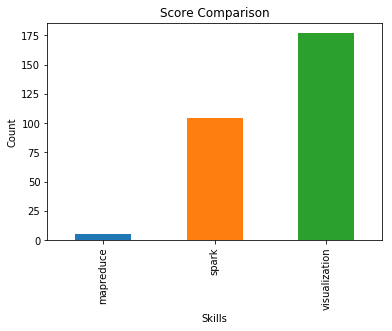

In [22]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Score Comparison')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

**Answer 7**:
I reused the same variables for Question 5 by copy and pasting so the code above Question 7 should already rerun to reflect the count of the 3 data science skills on the first 200 job ads.

## Lab 4.B: Data analysis of job skills
In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills. In this part of the lab we are asking you to create pandas `DataFrame` object as a table whose rows correspond to individual ads and columns correspond to important information about the ads and skills mentioned on those pages. Let us call the table `job_ads`. Process the first 1,000 data science ads, so your table should have 1,000 rows. For each ad, you will have to create the following columns:
- job title
- company name
- job location
- skill 1
- skill 2
- ...
- skill 20

Job title, company name, and job locations will be readable from the Indeed.com page. We are asking you to list 20 skills, instead of only 3 in the code above ('mapreduce', 'spark', 'visualization'). You will need to find another 17 words that are commonly used in data science job ads. To do it, please explore the content of at least 10 ads.

Once you creat your `job_ads` table, please preform EDA of the table, in a similar way you did in Lab 2: provide code and a 2-page document that summarizes interesitng insights about the first 1,000 data science jobs.

**Deliverables**:
- the modified Lab 4 .ipynb file that contains all the answers to the questions
- a 2-page documents presenting the results of your EDA of the `job_ads` data

In [23]:
## Reusing the code from Questions 4 and 6 to remake a new dictionary storing the 20 most common skills

## Changes: Range is now in (100) to capture the first 1000 job ads assuming 10 ads per page.
    ## Also put skill_set dictionary within the for loop to count for each job rather than a final sum

## Removed: Took out the counter check as it's not needed anymore.

## Added: code that captures job title, company name, and job location and puts it into a list called job_headers.
    ##  Made a list for skill_set dictionaries to put into list of dicts.

base_url = 'http://www.indeed.com'
job_links = []
for i in range(100): #do range(num_pages) if you want them all
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = requests.get(url).text
    bs_tree = bs4.BeautifulSoup(html_page)
    job_postings = bs_tree.findAll('div', attrs={'class':'jobsearch-SerpJobCard'})
    job_ids = [jp.get('data-jk') for jp in job_postings]
    # go after each link   
    for id in job_ids:
        job_links.append(base_url + '/viewjob?jk=' + id)

print("We found a lot of jobs: ", len(job_links))

We found a lot of jobs:  1561


In [24]:
job_headers = []
skills_list = []

counter = 0
for link in job_links[:1000]:
    counter +=1  
    
    try:
        html_page = requests.get(link).text
    except urllib2.HTTPError:
        print("HTTPError:")
        continue
    except urllib2.URLError:
        print("URLError:")
        continue
    except socket.error as error:
        print("Connection closed")
        continue

    skill_set = {'visualization':0, 'spark':0, 'data analysis':0, 'scripting':0, 'matlab':0,
            'python':0, 'sql':0, 'collaboration':0, 'communication':0, 'machine learning':0,
            'tableau':0, 'modeling':0, 'data mining':0, 'algorithms':0, 'natural language processing':0,
             'query':0, 'statistic':0, 'excel':0, 'powerpoint':0, 'large datasets':0}
    html_text = re.sub("[^a-zA-Z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key] +=1
    
    ## Appending to list of skills that each ad is requiring, 1 means it's required, 0 means not.
    skills_list.append(skill_set)
    
    ad_source = bs4.BeautifulSoup(html_page)
    ad_header = ad_source.find('div', attrs={'class':'jobsearch-DesktopStickyContainer'})
    ## I added the following if statement to see why does my for loop exit prior to completion
    ## Finding: At random times, there is an error with acquiring ad_header.find() which
        ## returns a 'NoneType'
    if ad_header == None: print(counter)
    job_title = ad_header.find('h3', attrs={'class':'icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title'}).get_text()
    company_name = ad_header.find('div', attrs = {'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'}).get_text()
    job_parsed = ad_header.div.div   ## getting job_location required a bit more work to pinpoint specific tag
    job_parsed = job_parsed.find_all('div')    ## there was no id/class so I had to use find_all for a list
    job_parsed = job_parsed[-1].get_text()     ## then get the text which is the location stored as a string
    no_digits = ["".join(str(a)) for a in job_parsed if not a.isdigit()]   ## remove all zip code digits
    job_location = ''.join(no_digits)
    job_headers.append([job_title,company_name,job_location])   ## append to list for all headers
    ##print(job_headers[counter-1]) Used to check if job_headers stored properly
    ##print(skill_set)     Used to check if skill_set stored properly

In [25]:
## Putting the job titles, company names, and job locations into rows as a dataframe
ads_headerDF = pd.DataFrame(job_headers, columns=['job_title','company_name,','job_location'])
#print(ads_headerDF)

## Formatting the skills_list as a dataframe as well
skills_df = pd.DataFrame(skills_list)
#print(skills_df)

## Joining the two dataframes together based on key numerical index
job_ads = ads_headerDF.join(skills_df)
print(job_ads)

                                             job_title  \
0                                       Data Scientist   
1                                       Data Scientist   
2                           Data Scientist, Engagement   
3                                       Data Scientist   
4                                       Data Scientist   
5                                       Data Scientist   
6                                       Data Scientist   
7    Data Scientist/Junior Data Scientist - Clevela...   
8                                       Data Scientist   
9                                       Data Scientist   
10                                      Data Scientist   
11                               Junior Data Scientist   
12                        Data Scientist Intern - 2019   
13                                      Data Scientist   
14                                      Data Scientist   
15                                      Data Scientist   
16         Hir

In [26]:
skills_sum = job_ads.sum()
skills_sum = skills_sum.drop(labels =['job_title','company_name,','job_location'])
print(skills_sum)

algorithms                      429
collaboration                   157
communication                   480
data analysis                   260
data mining                     277
excel                           557
large datasets                   65
machine learning                736
matlab                          171
modeling                        409
natural language processing     109
powerpoint                       82
python                          799
query                          1000
scripting                       130
spark                           310
sql                             614
statistic                       865
tableau                         293
visualization                   535
dtype: object


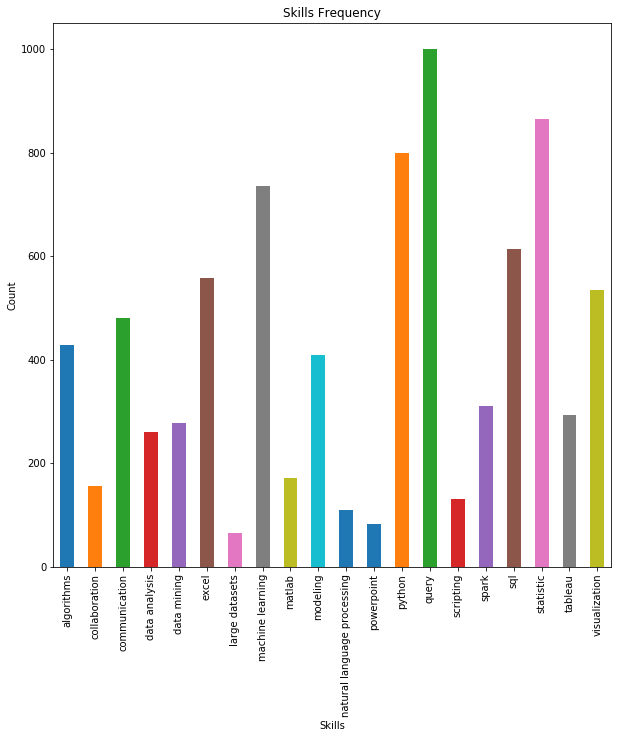

In [27]:
plt.title('Skills Frequency')
plt.xlabel('Skills')
plt.ylabel('Count')
skills_sum.plot(kind = 'bar', figsize=(10,10))

In [73]:
location_DF = job_ads.groupby('job_location').count()
location_DF = location_DF.sort_values(by=['job_title'])
location_DF = location_DF['job_title']
print(location_DF)

job_location
Albany, NY                  1
Irvine, CA                  1
Indianapolis, IN            1
Horsham, PA                 1
Raleigh, NC                 1
Raleigh, NC                 1
Herndon, VA                 1
Renton, WA                  1
Richardson, TX              1
Green Bay, WI               1
Richmond, VA                1
Gaithersburg, MD            1
Framingham, MA              1
Fort Washington, PA         1
Fort Mill, SC               1
Fairfax, VA                 1
Round Lake, IL              1
Ellicott City, MD           1
Northville, MI              1
Round Lake, IL              1
Saint Paul, MN              1
San Bruno, CA               1
Irving, TX                  1
San Diego, CA               1
Itasca, IL                  1
King of Prussia, PA         1
North Reading, MA           1
Newton, MA                  1
Newport Beach, CA           1
Orange, CA                  1
                         ... 
Philadelphia, PA            4
Chicago, IL                

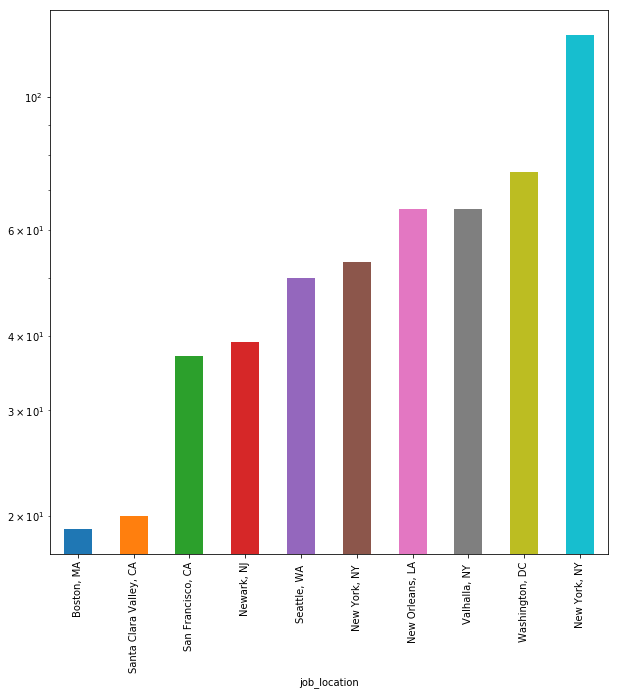

In [66]:
location_DF.tail(10).plot.bar(y='job_title',figsize=(10,10),logy=True)